In [2]:
import sys, glob, itertools
import numpy as np
import qiskit

import networkx as nx
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

import utils.graph_funcs as graph_funcs
import utils.helper_funcs as helper_funcs

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm
import qsplit_dqva_methods as qdm

# Reimplement demo

In [3]:
max_cuts = 1
mixing_layers = 2
shots = 500000

verbosity = 1
barriers = 2
decompose_toffoli = 1

dist_cutoff = 1e-4

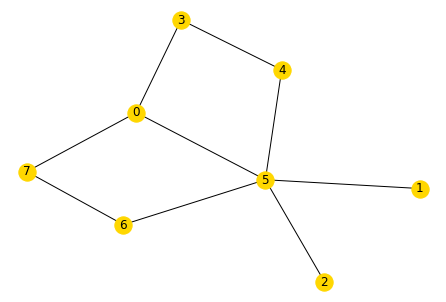

In [4]:
test_graphs = glob.glob("benchmark_graphs/N8_p30_graphs/*")
test_graph = np.random.choice(test_graphs)
G = graph_funcs.graph_from_file(test_graph)
qubit_num = G.number_of_nodes()
nx.draw_spring(G, with_labels=True, node_color='gold')

Partition: ({0, 3, 6, 7}, {1, 2, 4, 5})
Cut edges: [(0, 5), (3, 4), (5, 6)]


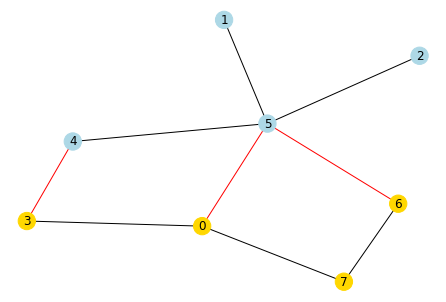

In [15]:
partition = kernighan_lin_bisection(G)
print('Partition:', partition)
subgraphs, cut_edges = graph_funcs.get_subgraphs(G, partition)
print('Cut edges:', cut_edges)
graph_funcs.view_partition(partition, G)

In [20]:
cut_nodes, hot_nodes = qdm.choose_nodes(G, subgraphs, cut_edges, max_cuts)
uncut_nodes = list(set(G.nodes).difference(set(cut_nodes)))
print('Cut nodes:', cut_nodes, 'Uncut nodes:', uncut_nodes)
print('Hot nodes:', hot_nodes)

Cut nodes: [0, 5, 3, 4, 5, 6] Uncut nodes: [1, 2, 7]
Hot nodes: [0, 6]


In [21]:
init_state = '0'*qubit_num
uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
num_params = mixing_layers * (uncut_nonzero + 1) + len(hot_nodes)
params = list(range(1, num_params + 1))
mixer_order = list(range(qubit_num))
np.random.shuffle(mixer_order)

In [24]:
circuit, cuts = qdm.gen_cut_dqva(G, partition, cut_nodes, mixing_layers=mixing_layers,
                                 params=params, init_state=init_state, barriers=barriers,
                                 decompose_toffoli=decompose_toffoli, mixer_order=mixer_order,
                                 hot_nodes=hot_nodes, verbose=verbosity)
print('circuit:')
print(circuit.draw(fold=180))
print(cuts)
print()

Current partition: ({0, 3, 6, 7}, {1, 2, 4, 5})
subgraphs: [[0, 3, 6, 7], [1, 2, 4, 5]]
cutedges: [(0, 5), (3, 4), (5, 6)]
hot nodes: [0, 6]
alpha_0: [1, 2, 3, 4, 5]
gamma_0: 6
alpha_1: [5, 6, 7]
gamma_1: 8
Mixer order: [0, 7, 6, 3, 4, 2, 1, 5]
init_state: 00000000, alpha: [1, 2, 3, 4, 5], pad_alpha: [1, 5, 4, None, None, None, 3, 2]
Subgraph dict: {0: 0, 3: 0, 6: 0, 7: 0, 1: 1, 2: 1, 4: 1, 5: 1}
qubit: 0 num_qubits = 10 neighbors: [3, 5, 7]
qubit: 7 num_qubits = 10 neighbors: [0, 6]
qubit: 6 num_qubits = 10 neighbors: [5, 7]
qubit: 2 num_qubits = 10 neighbors: [5]
qubit: 1 num_qubits = 10 neighbors: [5]
Mixer order: [0, 7, 6, 3, 4, 2, 1, 5]
init_state: 00000000, alpha: [5, 6, 7], pad_alpha: [None, 7, 6, None, None, None, None, 5]
Subgraph dict: {0: 0, 3: 0, 6: 0, 7: 0, 1: 1, 2: 1, 4: 1, 5: 1}
qubit: 7 num_qubits = 10 neighbors: [0, 6]
qubit: 2 num_qubits = 10 neighbors: [5]
qubit: 1 num_qubits = 10 neighbors: [5]
circuit:
        ░                ┌───────┐                ░ ┌───┐      